# A differentiable simulator for fitting spectra and concentrations

This is a more advanced work in progress after WaterSubtract.ipynb that attempts to simultaneously fit several parameters to match a given multi-spectral observation. It's main goal is to allow for spectrum confounders that arise from absorption/scattering removal through an intervening medium (tissue).

Let $Q_{i,j}$ represent emission from the $i$th species in the $j$th wavelength, and let $c_i$ be some fractional volume contribution of each of the $i$ species. Our overall goal is to estimate $\vec{c} = [c_1, c_2, c_3]^T$ in each pixel, updating the spectral shapes $\vec{Q}_i$ in all wavelengths from each species. We allow for a confounding removal due to a wavelength-dependent, total (absorption + scattering) opacity, $\mu_{t,j}$, currently set to be water at an unknown depth, $d$. Overall, this means that the wavelength-dependent output in each ROI is:

$$ \hat{y}_j = \sum_{i=1}^3 c_i Q_{i,j} e^{-d \mu_{t,j}}$$

This can then be compared with the *actual* output in each ROI, $y_j$, the error between the two can be calculated, and the parameters can then be adjusted to make the errors smaller.  We use a pytorch `nn.Module` to enable automatic differentiation and dynamic adjustments of this nonlinear model fit. Note that I've left off indices over each pixel/ROI that will also be used in the optimization (say, $n=1:N$); we assume that the $Q_{i,j}$ are the same for *all* ROIs and pixels; only the species concentrations $\vec{c}_n$ and depth $d_n$ are allowed to vary in each ROI/pixel.

We note that this currently assumes the same depth for all emitters, implying that there is some spatial averaging/smearing that will occur in the depth direction. A future direction might be to allow each emitter to have its own depth, and, eventually, allow a depth distribution of emission. Future work further still would be to enable scattering by assuming each species isotropically emits from its location and tracking bounces back to the camera.

Note that you will need to `conda install pytorch` to run this notebook.


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import nnls
from torch.nn.utils.convert_parameters import vector_to_parameters, parameters_to_vector

ModuleNotFoundError: No module named 'torch'

<Axes: title={'center': 'Reference Spectra'}>

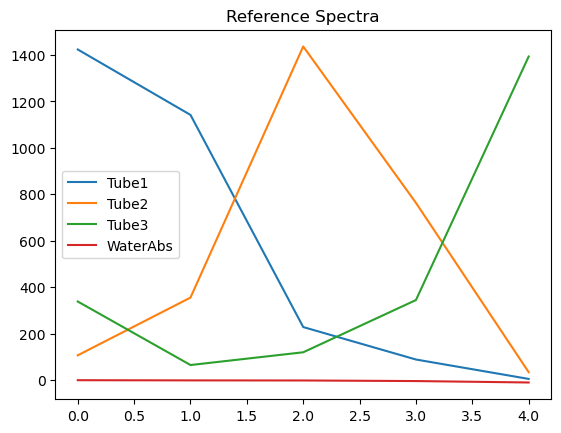

In [ ]:
df_ref_w = pd.DataFrame({ 'Tube1': [1423.39, 1141.72, 228.56, 88.83, 5.32],
                        'Tube2': [106.93, 355.45, 1436.32, 763.09, 34.49],
                        'Tube3': [338.49, 65.13, 119.99, 344.86, 1393.15],
                        'WaterAbs': [-5234, -4604, -4097, -2904, -88.3, -507.6]})

df_ref_3 = pd.DataFrame({ 'Tube1': [1423.39, 1141.72, 228.56, 88.83, 5.32],
                        'Tube2': [106.93, 355.45, 1436.32, 763.09, 34.49],
                        'Tube3': [338.49, 65.13, 119.99, 344.86, 1393.15]})

A = torch.Tensor(df_ref_3.to_numpy())
df_ref_w.plot(title="Reference Spectra")

### Initial work to build the raw functionality needed for the forward simulation 

In [ ]:
def attenuate(mu_t, depth):
    return torch.exp(-mu_t * depth)

In [ ]:
src = torch.Tensor(df_ref_w.Tube1)
mu_t = torch.Tensor(-df_ref_w.WaterAbs)
depth = torch.Tensor([1.0])
src.requires_grad = True
depth.requires_grad = True

In [ ]:
def forward_solve(sources, mu_t, depth, concentrations):
    """
    Solves the forward problem for a given set of sources and concentrations.
    """
    yhat = concentrations.matmul(sources * attenuate(mu_t, depth))

    return yhat

In [ ]:
sources = torch.Tensor(df_ref_3.to_numpy().T)
sources

tensor([[1423.3900, 1141.7200,  228.5600,   88.8300,    5.3200],
        [ 106.9300,  355.4500, 1436.3199,  763.0900,   34.4900],
        [ 338.4900,   65.1300,  119.9900,  344.8600, 1393.1500]])

In [ ]:
df = pd.DataFrame({'LN11': [1470.80, 945.80, 873.39, 1074.45, 1365.31],
                   'axialLN': [2024.43, 1411.94, 970.24, 776.86, 613.87],
                   'inguinalLN': [687.53, 707.53, 2577.45, 2087.88, 1318.48],
                   'inguinaldrain': [622.79, 337.08, 1279.45, 1185.42, 1429.32],
                   'blood': [950.06, 285.12, 1252.32, 1896.81, 2420.01],
                   'liver': [2269.90, 671.92, 2797.94, 3048.42, 3135.33]})

In [ ]:
y = torch.tensor(df.blood)
concentrations = torch.Tensor([1.0, 1.0, 1.0])
y_hat = forward_solve(sources, mu_t, depth, concentrations)
(y - y_hat).norm()

tensor(3225.9047, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

## Build a differentiable forward solver

The easiest way (in the pytorch ecosystem) to make a general fitting function is to
1. inherit from torch.nn.Module and
2. register "learnable parameters" with the module

This opens up a bunch of easy-to-use loss functions and optimization approaches in that ecosystem.

In [ ]:
class MyModel(torch.nn.Module):
    """
    A very simple simulation that, given a set of light sources, depths, and concentrations, produces
    the expected light intensity at each wavelength.

    The learnable parameters are the source spectra (sources), the concentrations of each species (concentrations), 
    and the depth of the absorbing/scattering medium (depths).
    """
    def __init__(self, 
                 initial_sources: torch.Tensor,
                 depths: torch.Tensor, 
                 concentrations: torch.Tensor,
                 mu_t: torch.Tensor):
        super().__init__()
        self.sources = torch.nn.Parameter(initial_sources, requires_grad=True)
        self.depths = torch.nn.Parameter(depths, requires_grad=True)
        self.concentrations = torch.nn.Parameter(concentrations, requires_grad=True)
        self.register_parameter('sources', self.sources)
        self.register_parameter('depths', self.depths)
        self.register_parameter('concentrations', self.concentrations)
        self.mu_t = mu_t 
        self.mu_t.requires_grad = False

        
    def attenuate(self, mu_t, depth):
        """Attenuate light with Beer's law.
        
        Parameters
        ----------
        mu_t : array-like
            Absorption + Scattering (total) coefficients at each wavelength.
        depth : torch.float
            Depth of the absorbing/scattering medium
        
        Returns
        -------
        array-like
            Attenuated light at each wavelength.
        """
        return torch.exp(-mu_t * depth)
    
    def forward_single(self, sources: torch.Tensor, depths: torch.Tensor, concentrations: torch.Tensor, mu_t: torch.Tensor):
        """
        For a single ROI/pixel, calculate the expected light intensity at each wavelength.

        Parameters
        ----------
        sources : torch.Tensor
            Light source intensities at each wavelength.
        depths : torch.Tensor
            Depth of the absorbing/scattering medium
        concentrations : torch.Tensor
            Concentrations of each species
        mu_t : torch.Tensor
            Absorption + Scattering (total) coefficients at each wavelength.
        
        Returns
        -------
        torch.Tensor
            Expected light intensity at each wavelength.
        """
        return torch.matmul(concentrations, (sources*attenuate(mu_t, depths)))

    def forward(self):
        """
        Calculate the expected light intensity at each wavelength for all ROI/pixels

        Returns
        -------
        torch.Tensor
            Expected light intensity at each wavelength for all ROI/pixels

        Note that this function *must* be defined when inheriting from torch.nn.Module,
        and it is what gets run when you call the model directly with () 
        """
        vm_fs = torch.vmap(self.forward_single, in_dims=(None, 0, 0, None))
        return vm_fs(self.sources,self.depths, self.concentrations, self.mu_t)

In [ ]:
# Test to see if it works without errors
concentrations = torch.ones((5,3), dtype=torch.float32)
depths = torch.ones((5,1), dtype=torch.float32)
my_model = MyModel(sources, depths, concentrations, mu_t)
print(my_model.forward())

tensor([[1.5301e+03, 5.7474e+02, 4.6271e+02, 2.4225e+01, 6.5056e-02],
        [1.5301e+03, 5.7474e+02, 4.6271e+02, 2.4225e+01, 6.5056e-02],
        [1.5301e+03, 5.7474e+02, 4.6271e+02, 2.4225e+01, 6.5056e-02],
        [1.5301e+03, 5.7474e+02, 4.6271e+02, 2.4225e+01, 6.5056e-02],
        [1.5301e+03, 5.7474e+02, 4.6271e+02, 2.4225e+01, 6.5056e-02]],
       grad_fn=<SqueezeBackward5>)


In [ ]:
# *** Choose a label from the above dataframe ***
y = df.axialLN.to_numpy()

# Solve the least squares problem to find the weights
w, res = nnls(A, y)

# Print the results
print(w)
print(res)

[1.19235983 0.48012958 0.46277767]
250.871879924097


In [ ]:
ys = df.to_numpy()
print(ys.shape)
initial_concentrations = torch.Tensor(np.apply_along_axis(lambda b: nnls(A,b)[0], 1, ys.T))
initial_concentrations

(5, 6)


tensor([[0.6976, 0.5017, 1.0173],
        [1.1924, 0.4801, 0.4628],
        [0.0674, 1.8239, 0.9634],
        [0.0659, 0.8436, 1.0430],
        [0.0458, 0.8974, 1.8241],
        [0.4913, 1.8551, 2.3961]])

In [ ]:
depths = 0.001*torch.ones(initial_concentrations.shape[0])
my_model = MyModel(sources, depths, initial_concentrations, mu_t)
my_model() - torch.Tensor(df.to_numpy().T)

tensor([[ -80.1987,   94.1730,  127.4084, -281.9017,   58.5819],
        [-119.6322,  148.6425,   46.0612, -147.4267,   47.1088],
        [ -70.5355,   79.7313,  169.6140, -364.5454,   73.0032],
        [ -85.8968,  105.4589,   70.6396, -180.0369,   38.4940],
        [-171.6654,  204.4214,  263.9008, -584.0173,  126.8865],
        [-561.5347,  703.0590,  262.1655, -771.7993,  235.4551]],
       grad_fn=<SubBackward0>)

In [ ]:
sources = torch.Tensor(df_ref_3.to_numpy().T)
y_true = torch.Tensor(df.to_numpy().T)

# Normalize the spectra
s_max = sources.max()
with torch.no_grad():
    sources = sources/s_max
    y_true = y_true/s_max

# Initialize the model
depths = 0.001*torch.ones(initial_concentrations.shape[0])
my_model = MyModel(sources, depths, initial_concentrations, mu_t)

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

def closure():
    optimizer.zero_grad()
    loss = loss_fn(my_model(), y_true)
    loss.backward()
    return loss

for t in range(10000):

    # Forward pass: compute predicted y by passing x to the model.
    y_pred = my_model()

    # Compute and print loss.
    loss = loss_fn(y_pred, y_true)
    if t % 1000 == 999:
        print(t+1, loss.item())
    
    # Zero out the gradients from the last step
    optimizer.zero_grad()

    # Calculate gradients
    loss.backward() 

    # Adjust the parameters (spectra and depths) using the gradients
    old_params = parameters_to_vector(my_model.parameters())
    #optimizer.step(closure) # For LBFGS
    optimizer.step()

    # Constrain the spectra and depths to be nonnegative
    with torch.no_grad():
        for param in my_model.parameters():
            param.clamp_(min=0.0)
            if param.name == 'depths':
                param.clamp(max=1.0)

    current_params = parameters_to_vector(my_model.parameters())
    if any(np.isnan(current_params.data.cpu().numpy())):
        print("Optimization diverged. Rolling back update...")
        vector_to_parameters(old_params, my_model.parameters())
        break



1000 0.15757082402706146
2000 0.10847429186105728
3000 0.07762343436479568
4000 0.05081506818532944
5000 0.03324512392282486
6000 0.02608867734670639
7000 0.0240224190056324
8000 0.022999556735157967
9000 0.022098977118730545
10000 0.021380513906478882


In [ ]:
my_model.depths

Parameter containing:
tensor([0.0196, 0.0812, 0.0000, 0.0000, 0.0237, 0.0677], requires_grad=True)

In [ ]:
my_model.concentrations

Parameter containing:
tensor([[0.7486, 0.5761, 0.6827],
        [1.2718, 0.6129, 0.3940],
        [0.3084, 1.9013, 0.2811],
        [0.1605, 0.9009, 0.5788],
        [0.0188, 1.0269, 1.5560],
        [0.2794, 2.2266, 2.9849]], requires_grad=True)

In [ ]:
my_model.sources

Parameter containing:
tensor([[0.9808, 0.7757, 0.1423, 0.1350, 0.2486],
        [0.0335, 0.1291, 0.9275, 0.6683, 0.2674],
        [0.4140, 0.0075, 0.0000, 0.4336, 1.2075]], requires_grad=True)

<Axes: >

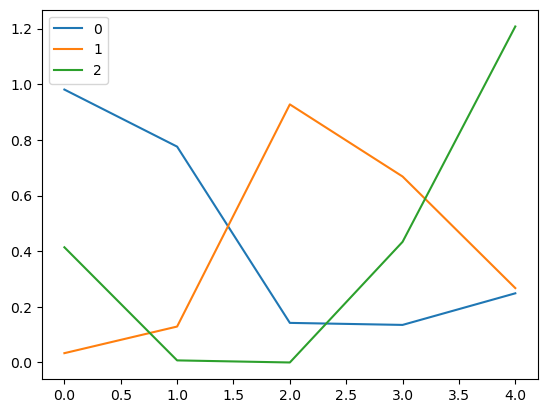

In [ ]:
pd.DataFrame(my_model.sources.detach().numpy().T).plot()

## Fingers crossed, let's try on the tubes and the mouse!


In [ ]:
tube_array = np.load('../data/tube_input_matrix.npy')
tube_array = np.delete(tube_array, 4,1) # Remove the 5th column

# Apply a function across each row of the numpy array to get an initial guess
tube_array_conc = torch.Tensor(np.apply_along_axis(lambda b: nnls(A,b)[0], 1, tube_array))
sources = torch.Tensor(df_ref_3.to_numpy().T)
y_true = torch.Tensor(tube_array)

# Normalize the spectra
s_max = sources.max()
with torch.no_grad():
    sources = sources/s_max
    y_true = y_true/s_max

depths = 0.001*torch.ones(tube_array_conc.shape[0])


In [ ]:
my_model = MyModel(sources, depths, tube_array_conc, mu_t)
#loss_fn = torch.nn.MSELoss(reduction='sum')
loss_fn = torch.nn.HuberLoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

def closure():
    optimizer.zero_grad()
    loss = loss_fn(my_model(), y_true)
    loss.backward()
    return loss

for t in range(4000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = my_model()

    # Compute and print loss.
    loss = loss_fn(y_pred, y_true)
    if t % 100 == 99:
        print(t+1, loss.item())
    
    # Zero out the gradients from the last step
    optimizer.zero_grad()

    # Calculate gradients
    loss.backward() 

    # Adjust the parameters (spectra and depths) using the gradients
    old_params = parameters_to_vector(my_model.parameters())
    #optimizer.step(closure) # For LBFGS
    optimizer.step()

    # Constrain the spectra and depths to be nonnegative
    with torch.no_grad():
        for param in my_model.parameters():
            param.clamp_(min=0.0)

    current_params = parameters_to_vector(my_model.parameters())
    if any(np.isnan(current_params.data.cpu().numpy())):
        print("Optimization diverged. Rolling back update...")
        vector_to_parameters(old_params, my_model.parameters())
        break


100 46.48393630981445
200 39.30171585083008
300 33.354270935058594
400 28.43437385559082
500 24.379932403564453
600 21.052888870239258
700 18.33493423461914
800 16.124366760253906
900 14.333146095275879
1000 12.886022567749023
1100 11.718795776367188
1200 10.77762222290039
1300 10.017624855041504
1400 9.401762008666992
1500 8.899781227111816
1600 8.487544059753418
1700 8.1460542678833
1800 7.860552787780762
1900 7.619611740112305
2000 7.4144792556762695
2100 7.238386154174805
2200 7.085975646972656
2300 6.954708099365234
2400 6.841283798217773
2500 6.741336822509766
2600 6.652366638183594
2700 6.572381496429443
2800 6.499791145324707
2900 6.433324813842773
3000 6.371963024139404
3100 6.314871788024902
3200 6.261369228363037
3300 6.210878849029541
3400 6.163511276245117
3500 6.119139671325684
3600 6.077058792114258
3700 6.036913871765137
3800 5.998444557189941
3900 5.961437225341797
4000 5.9284491539001465


In [ ]:
my_model.sources

Parameter containing:
tensor([[0.8878, 0.8912, 0.0532, 0.0000, 0.0000],
        [0.0598, 0.0686, 1.1306, 0.7202, 0.0000],
        [0.0922, 0.0971, 0.0000, 0.1872, 1.1360]], requires_grad=True)

<Axes: >

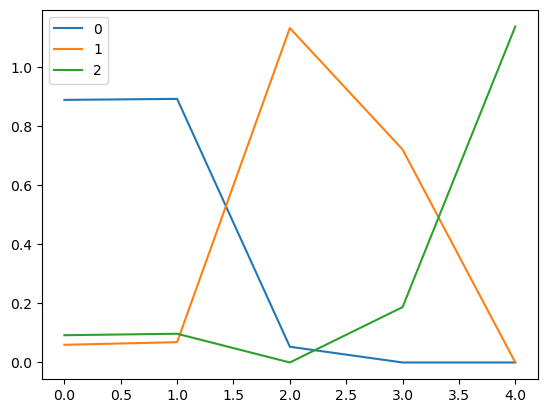

In [ ]:
pd.DataFrame(my_model.sources.detach().numpy().T).plot()

In [ ]:
def make_image(ax_in, concentrations, reshape):
    ps = np.reshape(concentrations, reshape)
    ax_in.imshow(ps, cmap='gray')

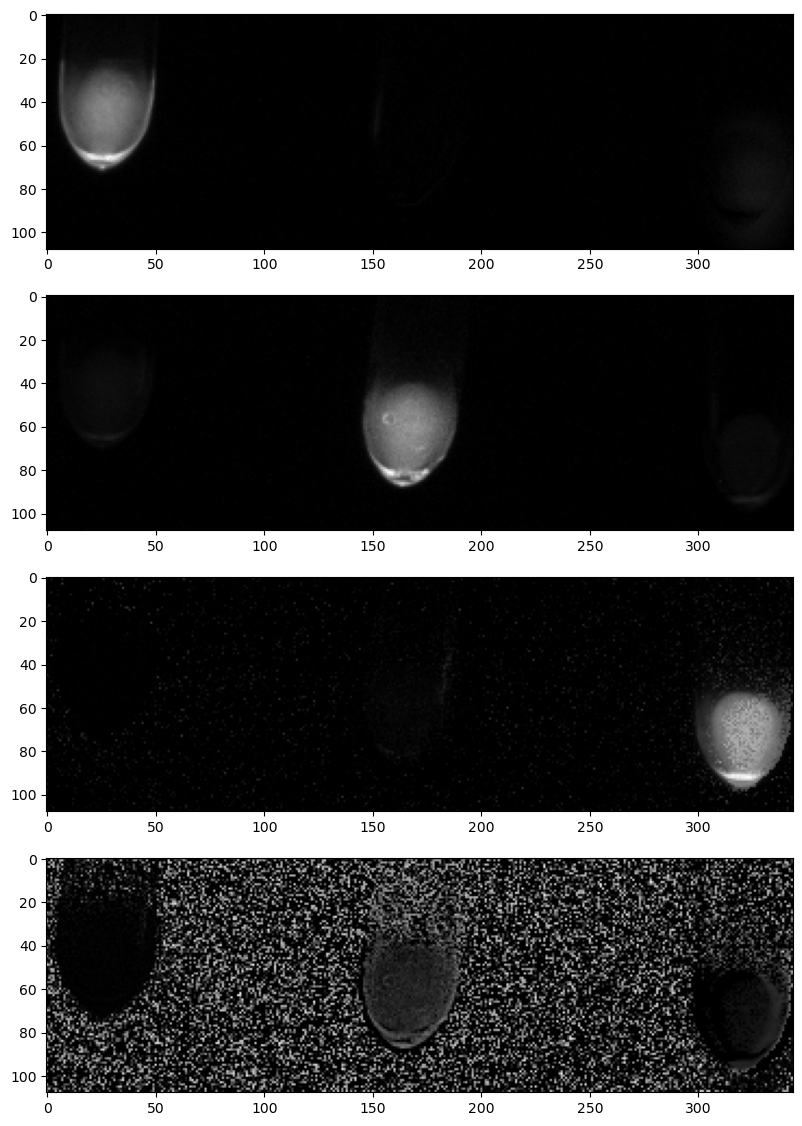

In [ ]:
tube_shape = (108,344)
# Convert the weights to an WxL image
sfig, ax = plt.subplots(4,1, figsize=(12,14))
make_image(ax[0], my_model.concentrations.detach().numpy()[:,0], tube_shape)
make_image(ax[1], my_model.concentrations.detach().numpy()[:,1], tube_shape)
make_image(ax[2], my_model.concentrations.detach().numpy()[:,2], tube_shape)
make_image(ax[3], my_model.depths.detach().numpy(), tube_shape)

The last frame has the depths, which appears speckled, probably because one way to get no light output is to make the depths arbitrarily large.

In [ ]:
mouse_array = np.load('../data/mouse_input_matrix.npy')
mouse_array = np.delete(mouse_array, 4,1) # Remove the 5th column
# Apply a function across each row of the numpy array to get an initial guess
mouse_array_conc = torch.Tensor(np.apply_along_axis(lambda b: nnls(A,b)[0], 1, mouse_array))
sources = torch.Tensor(df_ref_3.to_numpy().T)
y_true = torch.Tensor(mouse_array)

# Normalize the spectra
s_max = sources.max()
with torch.no_grad():
    sources = sources/s_max
    y_true = y_true/s_max

depths = 0.001*torch.ones(mouse_array_conc.shape[0])

In [ ]:
my_model = MyModel(sources, depths, mouse_array_conc, mu_t)
#loss_fn = torch.nn.MSELoss(reduction='sum')
loss_fn = torch.nn.HuberLoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

def closure():
    optimizer.zero_grad()
    loss = loss_fn(my_model(), y_true)
    loss.backward()
    return loss

for t in range(5000):

    # Forward pass: compute predicted y by passing x to the model.
    y_pred = my_model()

    # Compute and print loss.
    loss = loss_fn(y_pred, y_true)
    if t % 100 == 99:
        print(t+1, loss.item())
    
    # Zero out the gradients from the last step
    optimizer.zero_grad()

    # Calculate gradients
    loss.backward() 

    # Adjust the parameters (spectra and depths) using the gradients
    old_params = parameters_to_vector(my_model.parameters())
    #optimizer.step(closure) # For LBFGS
    optimizer.step()

    # Constrain the spectra and depths to be nonnegative
    with torch.no_grad():
        for param in my_model.parameters():
            param.clamp_(min=0.0)

    current_params = parameters_to_vector(my_model.parameters())
    if any(np.isnan(current_params.data.cpu().numpy())):
        print("Optimization diverged. Rolling back update...")
        vector_to_parameters(old_params, my_model.parameters())
        break


100 5281.55712890625
200 4302.29248046875
300 3512.69921875
400 2877.205810546875
500 2353.564697265625
600 1922.8905029296875
700 1572.635498046875
800 1292.7745361328125
900 1073.8558349609375
1000 906.5005493164062
1100 781.5364379882812
1200 702.4156494140625
1300 645.1463012695312
1400 601.2587890625
1500 567.5418701171875
1600 541.3276977539062
1700 520.4815063476562
1800 503.35498046875
1900 488.7217102050781
2000 475.69635009765625
2100 463.6577453613281
2200 452.1994323730469
2300 441.0771179199219
2400 430.15740966796875
2500 419.3793640136719
2600 408.72113037109375
2700 398.1802062988281
2800 387.76507568359375
2900 377.48919677734375
3000 367.369140625
3100 357.42236328125
3200 347.6640319824219
3300 338.10919189453125
3400 328.7718505859375
3500 319.662109375
3600 310.7877197265625
3700 302.1523132324219
3800 293.75518798828125
3900 285.5914001464844
4000 277.65380859375
4100 269.93017578125
4200 262.4069519042969
4300 255.07144165039062
4400 247.9118194580078
4500 240.91

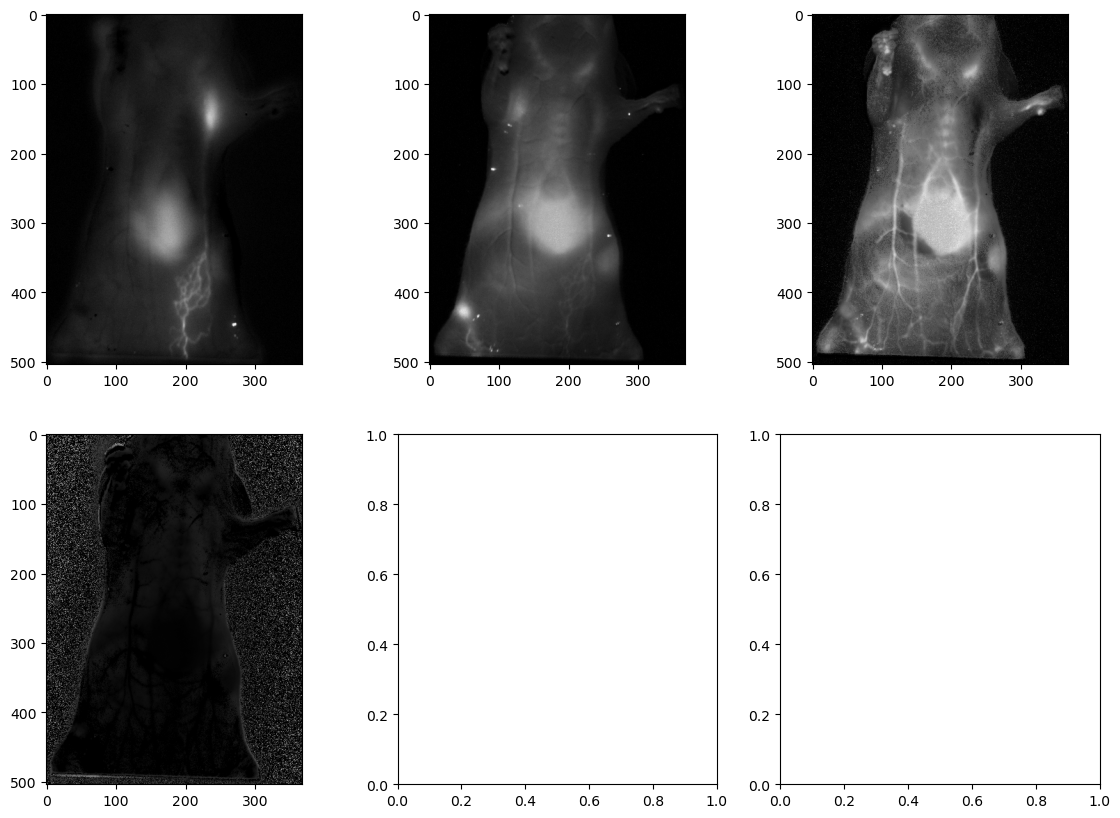

In [ ]:
mouse_shape = (504,368)

# Convert the weights to an WxL image
sfig, ax = plt.subplots(2,3, figsize=(14,10))
make_image(ax[0][0], my_model.concentrations.detach().numpy()[:,0], mouse_shape)
make_image(ax[0][1], my_model.concentrations.detach().numpy()[:,1], mouse_shape)
make_image(ax[0][2], my_model.concentrations.detach().numpy()[:,2], mouse_shape)
make_image(ax[1][0], my_model.depths.detach().numpy(), mouse_shape)

<Axes: >

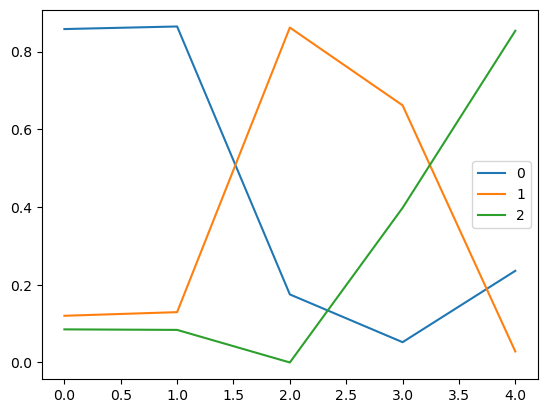

In [ ]:
pd.DataFrame(my_model.sources.detach().numpy().T).plot()